In [37]:
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from scipy import linalg
from collections import defaultdict

nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [39]:
def get_dict(data):
    """
    Input:
        K: the number of negative samples
        data: the data you want to pull from
        indices: a list of word indices
    Output:
        word2Ind: returns dictionary mapping the word to its index
        Ind2Word: returns dictionary mapping the index to its word
    """
    words = sorted(list(set(data)))
    idx = 0
    word2Ind = {}
    Ind2word = {}
    for k in words:
        word2Ind[k] = idx
        Ind2word[idx] = k
        idx += 1
    return word2Ind, Ind2word

In [40]:
def get_idx(words, word2Ind):
    idx = []
    for word in words:
        idx = idx + [word2Ind[word]]
    return idx

In [41]:
def pack_idx_with_frequency(context_words, word2Ind):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed

In [42]:
def get_vectors(data, word2Ind, V, C):
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)
        center_word = data[i]
        y[word2Ind[center_word]] = 1
        context_words = data[(i - C) : i] + data[(i + 1) : (i + C + 1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
            x[idx] = freq / num_ctx_words
        yield x, y
        i += 1
        if i >= len(data) - C:
            print("i is being set to", C)
            i = C

In [43]:
def get_batches(data, word2Ind, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2Ind, V, C):
        if len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch_x = []
            batch_y = []

In [44]:
def compute_pca(data, n_components=2):
    """
    Input: 
        data: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output: 
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """
    data -= data.mean(axis=0)
    R = np.cov(data, rowvar=False)
    evals, evecs = linalg.eigh(R)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:, idx]
    evals = evals[idx]
    evecs = evecs[:, :n_components]

    return np.dot(evecs.T, data.T).T

In [45]:
nltk.data.path.append('.')

In [46]:
import re                                                           #  Load the Regex-modul
with open('./data/shakespeare.txt') as f:
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punktuations are replaced by .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(data),'\n', data[:15])               #  print data sample

Number of tokens: 60976 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


In [47]:
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) )

Size of vocabulary:  5775
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752), ('you', 748), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


In [48]:
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  5775


In [49]:
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Word which has index 2744:  ",Ind2word[2744] )

Index of the word 'king' :   2744
Word which has index 2744:   king


In [50]:
def initialize_model(N,V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    np.random.seed(random_seed)
    # W1 has shape (N,V)
    W1 = np.random.rand(N, V)
    # W2 has shape (V,N)
    W2 = np.random.rand(V,N)
    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)
    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)
    
    return W1, W2, b1, b2

In [51]:
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


In [52]:
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer
    Outputs: 
        yhat: prediction (estimate of y)
    '''
    e_z = np.exp(z)
    yhat = e_z/np.sum(e_z,axis=0)
    return yhat

In [53]:
tmp = np.array([[1,2,3],
                [1,1,1]
               ])
tmp_sm = softmax(tmp)
display(tmp_sm)

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

In [54]:
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    h = np.dot(W1,x)+b1
    h = np.maximum(0,h)
    z = np.dot(W2,h)+b2

    return z, h

In [55]:
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


In [56]:
def compute_cost(y, yhat, batch_size):
    # compute_cost: cross-entropy cost function
    logprobs = np.multiply(np.log(yhat),y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [57]:
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))
        
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (5775, 4)
tmp_y.shape (5775, 4)
tmp_W1.shape (50, 5775)
tmp_W2.shape (5775, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5775, 1)
tmp_z.shape: (5775, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (5775, 4)
call compute_cost
tmp_cost 10.3511


In [58]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    z1 = np.dot(W1, x) + b1
    l1 = np.dot(W2.T, (yhat - y))
    l1[z1 < 0] = 0
    grad_W1 = np.dot(l1, x.T) / batch_size
    grad_W2 = np.dot(yhat - y, h.T) / batch_size
    grad_b1 = np.sum(l1, axis=1, keepdims=True) / batch_size
    grad_b2 = np.sum(yhat - y, axis=1, keepdims=True) / batch_size

    return grad_W1, grad_W2, grad_b1, grad_b2

In [59]:
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (5775, 4)
tmp_y.shape (5775, 4)

Initialize weights and biases
tmp_W1.shape (50, 5775)
tmp_W2.shape (5775, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (5775, 1)

Forwad prop to get z and h
tmp_z.shape: (5775, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (5775, 4)

call back_prop
tmp_grad_W1.shape (50, 5775)
tmp_grad_W2.shape (5775, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (5775, 1)


In [60]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03, 
                     random_seed=282, initialize_model=initialize_model, 
                     get_batches=get_batches, forward_prop=forward_prop, 
                     softmax=softmax, compute_cost=compute_cost, 
                     back_prop=back_prop):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
        random_seed: random seed to initialize the model's matrices and vectors
        initialize_model: your implementation of the function to initialize the model
        get_batches: function to get the data in batches
        forward_prop: your implementation of the function to perform forward propagation
        softmax: your implementation of the softmax function
        compute_cost: cost function (Cross entropy)
        back_prop: your implementation of the function to perform backward propagation
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases after num_iters iterations

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=random_seed) #W1=(N,V) and W2=(V,N)
    batch_size = 128
    iters = 0
    C = 2 
    
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        z, h = forward_prop(x, W1, W2, b1, b2)
        yhat = softmax(z)
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        W1 -= alpha*grad_W1 
        W2 -= alpha*grad_W2
        b1 -= alpha*grad_b1
        b2 -= alpha*grad_b2

        iters +=1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [61]:
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 9.513211
iters: 20 cost: 9.476105
iters: 30 cost: 9.543887
iters: 40 cost: 9.370119
iters: 50 cost: 8.752134
iters: 60 cost: 8.645475
iters: 70 cost: 8.777353
iters: 80 cost: 8.683993
iters: 90 cost: 8.785594
iters: 100 cost: 8.286367
iters: 110 cost: 8.527792
iters: 120 cost: 8.414913
iters: 130 cost: 8.099485
iters: 140 cost: 8.282044
iters: 150 cost: 8.239267


(10, 50) [2744, 3949, 2960, 3022, 5672, 1452, 5671, 4189, 2315, 4276]


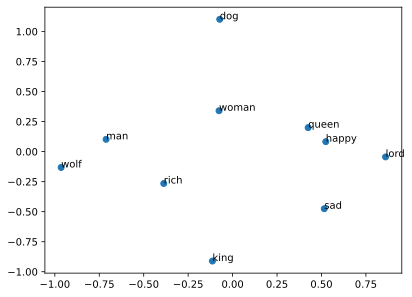

In [62]:
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0

idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)

result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

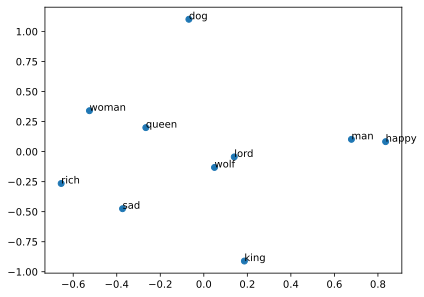

In [63]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()